# Sequence Bucketing

Instead of clustering directly, we start by pre bucketing using a SAX like algorithm.
First we compress each sequence to `n` symbols and then quantize using k-means.

In [ ]:
!cythonize -if ../ml_pipeline/sequence_hashing.pyx

In [3]:
import yaml
import sys
import os 
import tensorflow as tf
sys.path.append('..')
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.models import *

import imp
import ml_pipeline
imp.reload(ml_pipeline)

from ml_pipeline.audio import *
from ml_pipeline.dtw import * 
from ml_pipeline.sequence_hashing import *
from ml_pipeline.structured import * 
from ml_pipeline.audio_collection import * 
from ml_pipeline.sequence_embedder import *

In [ ]:
c = yaml.load(open('../config/default_config.yaml'))
print("Parameters: {}".format(c))
params = WindowParams(c['spec_win'], c['spec_step'], c['fft_win'], c['fft_step'], c['highpass'])

inp = 'gs://wdp-ds-data/dolphin_ogg'
out = '../models/v3_lstm_v1/'
enc = tf.keras.models.load_model("{}/encoder.h5".format(out))
silence         = load_model("{}/sil.h5".format(out))
type_classifier = load_model("{}/type.h5".format(out))
embedder = SequenceEmbedder(enc, silence, type_classifier, params)

for filename in tf.io.gfile.listdir(inp):
    if filename.endswith('.ogg') or filename.endswith('.wav'):
        name = filename.replace(".wav", "")
        name = name.replace(".ogg", "")            
        in_path  = "{}/{}".format(inp, filename)
        out_path = "{}/embedding_{}.csv".format(out, name)
        print("\t {}".format(in_path))
        if not os.path.isfile(out_path):
            inducer = TypeExtraction.from_audiofile(in_path, embedder)
            inducer.save(out_path, append=True)

In [5]:
re          = RegionExtractors(0)
overlapping = []
for file in tf.io.gfile.listdir('../models/v3_lstm_v1/'):        
    if file.startswith("embedding") and file.endswith(".csv"):
        path = "{}/{}".format('../models/v3_lstm_v1/', file)
        print("\tReading {}".format(path))
        header                = ["filename", "start", "stop", "type", "embedding"]
        df                    = pd.read_csv(path, sep="\t", header = None, names=header)
        signals               = df[df['type'] >= 1]
        signals['embedding']  = df['embedding'].apply(
            lambda x: np.array([float(i) for i in x.split(",")]))
        annotated             = [(row['start'], row['stop'], row['filename'], row['embedding'])
                                 for _ , row in signals.iterrows()]
        overlapping += groupBy(annotated, re.overlap)    

	Reading ../models/v3_lstm_v1//embedding_06080902.csv


In [6]:
pickle.dump(overlapping, open('overlapping.pkl', 'wb'))

## Filtering size 

In [ ]:
!cythonize -if ../ml_pipeline/sequence_hashing.pyx

In [1]:
import yaml
import sys
import os 
import tensorflow as tf
sys.path.append('..')
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.models import *

import imp
import ml_pipeline
imp.reload(ml_pipeline)

from ml_pipeline.audio import *
from ml_pipeline.dtw import * 
from ml_pipeline.sequence_hashing import *
from ml_pipeline.structured import * 
from ml_pipeline.audio_collection import * 

In [8]:
min_th = 2
max_th = 250
overlapping = [x for x in pickle.load(open('overlapping.pkl', 'rb'))]
lengths = [len(x[3]) for x in overlapping]
print(set(lengths))
overlapping = [x for x in overlapping if len(x[3]) > min_th and len(x[3]) < max_th]
sequences = [np.stack(s) for _, _, _, s in overlapping]
print(len(sequences), len(overlapping))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 116, 118, 119, 120, 7801, 122, 123, 124, 128, 130, 131, 133, 137, 138, 139, 140, 142, 143, 144, 145, 152, 154, 159, 163, 165, 172, 175, 178, 183, 184, 188, 189, 195, 203, 219, 234, 236}
30520 30520


## Bucket Result

In [9]:
assignments = similarity_bucketing(sequences, 3, 5)
clusters = max(assignments) + 1

PAA
Clustering (10000, 256) instances of 30520 instances
Done Clustering
Cluster usage:   [10120 25217 22117 12253 21853]
Cluster usage@n: [10120 25217 22117 12253 21853]


In [10]:
counts = np.zeros(clusters)
for i in assignments:
    counts[i] += 1

Percentile 5:  15.0
Percentile 10: 18.0
Percentile 50: 65.0
Percentile 90: 579.200000000001
Percentile 95: 957.8
max: 3445.0


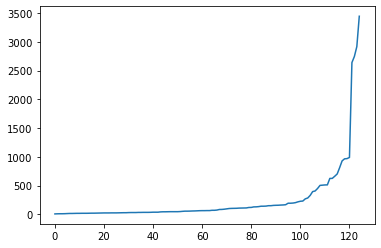

#Clusters 125
125
125
125
121
94


In [11]:
print("Percentile 5:  {}".format(np.percentile(counts, 5)))
print("Percentile 10: {}".format(np.percentile(counts, 10)))
print("Percentile 50: {}".format(np.percentile(counts, 50)))
print("Percentile 90: {}".format(np.percentile(counts, 90)))
print("Percentile 95: {}".format(np.percentile(counts, 95)))
print("max: {}".format(np.max(counts)))

plt.plot(sorted(counts))
plt.show()
print("#Clusters", clusters)
print(len(counts[counts > 1]))
print(len(counts[counts > 2]))
print(len(counts[counts > 3]))
print(len(counts[counts > 10]))
print(len(counts[counts > 30]))

In [12]:
by_assignment = {}
for o, s in zip(overlapping, assignments):
    if s not in by_assignment:
        by_assignment[s] = []
    by_assignment[s].append(o)

## Clustering In Each Bucket

+ Make this faster using all processors
+ https://wltrimbl.github.io/2014-06-10-spelman/intermediate/python/04-multiprocessing.html

In [13]:
import warnings
warnings.filterwarnings('ignore')


import multiprocessing as mp


def process(assignment, overlapping, max_dist):
    n = len(overlapping)
    if n > 1:
        max_len = int(max([len(e) for _, _, _, e in overlapping]) + 1)
        dtw = DTW(max_len)
        dist = np.zeros((n, n))
        for i, (start_x, stop_x, f_x, embedding_x) in enumerate(overlapping):
            if i % 250 == 0 and i > 0:
                print("\t\t Processing: {} {}".format(i, len(overlapping)))
            for j, (start_y, stop_y, f_y, embedding_y) in enumerate(overlapping):
                if i < j:
                    x = np.array([embedding_x]).reshape(len(embedding_x), 256)
                    y = np.array([embedding_y]).reshape(len(embedding_y), 256)
                    d, _       = dtw.align(x, y) 
                    dist[i, j] = d / (len(x) * len(y))
                    dist[j, i] = d / (len(x) * len(y))
        print("\t {} {} {} {} {} {} ".format(assignment, n, np.percentile(dist.flatten(), 5), np.percentile(dist.flatten(), 95), np.mean(dist), np.std(dist)))
        agg = AgglomerativeClustering(n_clusters = None, 
                                      distance_threshold = max_dist, linkage = 'average', affinity='precomputed')
        clustering = agg.fit_predict(dist)
        return clustering, overlapping
    return [], []


pool = mp.Pool(processes=10)
results = [pool.apply_async(process, args=(assignment, overlapping, 5.0)) for assignment, overlapping in by_assignment.items()]
outputs = [p.get() for p in results]


with open('clustering.csv', "w") as fp:
    cur = 0
    for clustering, overlapping in outputs:
        if len(clustering) > 0:
            for c, (start, stop, f, _) in zip(clustering, overlapping):
                fp.write("{},{},{},{}\n".format(start, stop, f, c + cur))
            for c in range(len(set(clustering))):
                cur += 1

		 Processing: 250 2639
		 Processing: 500 3445
		 Processing: 500 2917
		 Processing: 750 3445
		 Processing: 750 2917
		 Processing: 1000 3445
		 Processing: 500 2639
		 Processing: 1000 2917
		 Processing: 1250 3445
		 Processing: 1500 3445
		 Processing: 1250 2917
		 Processing: 750 2639
		 Processing: 1750 3445
		 Processing: 1500 2917
		 Processing: 2000 3445
		 Processing: 1000 2639
		 Processing: 1750 2917
		 Processing: 2250 3445
		 Processing: 2000 2917
		 Processing: 2500 3445
		 Processing: 2750 3445
		 Processing: 2250 2917
		 Processing: 3000 3445
		 Processing: 3250 3445
		 Processing: 2500 2917
	 19 3445 3.8218238784252176 25.173192810272198 13.649907549060307 6.718517091491274 
		 Processing: 2750 2917
	 5 2917 6.325504101833156 40.83734798993637 18.931436013204806 11.065117506967832 
		 Processing: 1250 2639
		 Processing: 1500 2639
		 Processing: 1750 2639
		 Processing: 2000 2639
		 Processing: 2250 2639
		 Processing: 2500 2639
	 29 2639 2.8264431854204966 27.45576

# Checkpoint

In [14]:
df = pd.read_csv('clustering.csv', names=['start', 'stop', 'file', 'clusters'], header = None)

Clusters: 24089
700
220
130
46
29


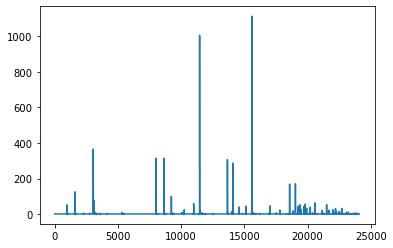

In [15]:
grouped_by_filename = {}
grouped_by_cluster  = {}
# instance id
clusters = []
for i, row in df.iterrows():
    start = row[0]
    stop = row[1]
    f = row[2]
    c = row[3]
    
    if c not in grouped_by_cluster:
        grouped_by_cluster[c] = {}
    if f not in grouped_by_cluster[c]:
        grouped_by_cluster[c][f] = []
    grouped_by_cluster[c][f].append((start, stop))
    
    if f not in grouped_by_filename:
        grouped_by_filename[f] = []
    grouped_by_filename[f].append((start, stop, c, i))
    clusters.append(c)
    
k = max(clusters) + 1
instances_clusters = np.zeros(k, dtype=np.int32)
for c, collection in grouped_by_cluster.items():
    for f, regions in collection.items():
        for r in regions:
            instances_clusters[c] += 1

print("Clusters: {}".format(k))
print(len(instances_clusters[instances_clusters > 1]))
print(len(instances_clusters[instances_clusters > 2]))
print(len(instances_clusters[instances_clusters > 3]))
print(len(instances_clusters[instances_clusters > 10]))
print(len(instances_clusters[instances_clusters > 30]))

plt.plot(instances_clusters)
plt.show()

In [16]:
import multiprocessing as mp

out = "../models/v3_lstm_v1/"

def write_audio(cluster_id, instances_clusters, grouped_by_cluster, min_support, max_support):
    if instances_clusters[cluster_id] > min_support and instances_clusters[cluster_id] < max_support:
        print("Audio result for cluster: {} {}".format(cluster_id, instances_clusters[cluster_id]))
        audio_bank = AudioSnippetCollection("{}/seq_cluster_{}.wav".format(out, cluster_id))
        for f, snippets in grouped_by_cluster[cluster_id].items():
            print("Cluster: {}, {}, {}".format(cluster_id, f, len(snippets)))
            for audio_snippet in audio_regions(f, snippets):                  
                audio_bank.write(audio_snippet)
        audio_bank.close()
        print("Done: {}".format(cluster_id))
        
pool = mp.Pool(processes=10)
results = [pool.apply_async(write_audio, args=(cluster_id, instances_clusters, grouped_by_cluster, 2, 500)) for cluster_id in range(0, k)]
outputs = [p.get() for p in results]

Cluster: 19258, gs://wdp-ds-data/dolphin_ogg/06281102.ogg, 1
Cluster: 18575, gs://wdp-ds-data/dolphin_ogg/06131001.ogg, 2
Cluster: 19033, gs://wdp-ds-data/dolphin_ogg/06101002_RegPCA110.ogg, 1
Cluster: 13653, gs://wdp-ds-data/dolphin_ogg/08081202 Canon.ogg, 1
Cluster: 19034, gs://wdp-ds-data/dolphin_ogg/060210N.ogg, 1
Cluster: 17803, gs://wdp-ds-data/dolphin_ogg/07161101.ogg, 4
Cluster: 18851, gs://wdp-ds-data/dolphin_ogg/07261201 Canon.ogg, 1
Cluster: 19033, gs://wdp-ds-data/dolphin_ogg/081910N.ogg, 10
Cluster: 17029, gs://wdp-ds-data/dolphin_ogg/07161101.ogg, 6
Cluster: 13653, gs://wdp-ds-data/dolphin_ogg/06160801_RegPCA110.ogg, 1
Done: 19258
Cluster: 19254, gs://wdp-ds-data/dolphin_ogg/05111101.ogg, 7
Cluster: 19034, gs://wdp-ds-data/dolphin_ogg/06141101C.ogg, 1
Cluster: 13653, gs://wdp-ds-data/dolphin_ogg/07050601_RegPCA110.ogg, 1
Cluster: 14078, gs://wdp-ds-data/dolphin_ogg/05161102.ogg, 2
Cluster: 19034, gs://wdp-ds-data/dolphin_ogg/08161101.ogg, 1
Cluster: 17803, gs://wdp-ds-dat

In [17]:
for cluster_id in range(0, k):
    for f, regions in grouped_by_filename.items():
        filename = f.split(".")[0].split("/")[-1]
        log_path = "{}/seq_clustering_log_{}.csv".format(out, filename)
        #instance id
        with open(log_path, "a+") as fp:
            for start, stop, c, i in regions:
                if c == cluster_id:
                    fp.write("{},{},{},{},{}\n".format(start, stop, f, c, i))                        